C:\Users\shaje\AppData\Local\Temp\ipykernel_10768\1956935971.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data_specified = data_specified.set_index('date_added').resample('M').mean().dropna()
c:\Users\shaje\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\shaje\AppData\Local\Temp\ipykernel_10768\1956935971.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=monthly_data_specified.index[-1], periods=13, freq='M')[1:]


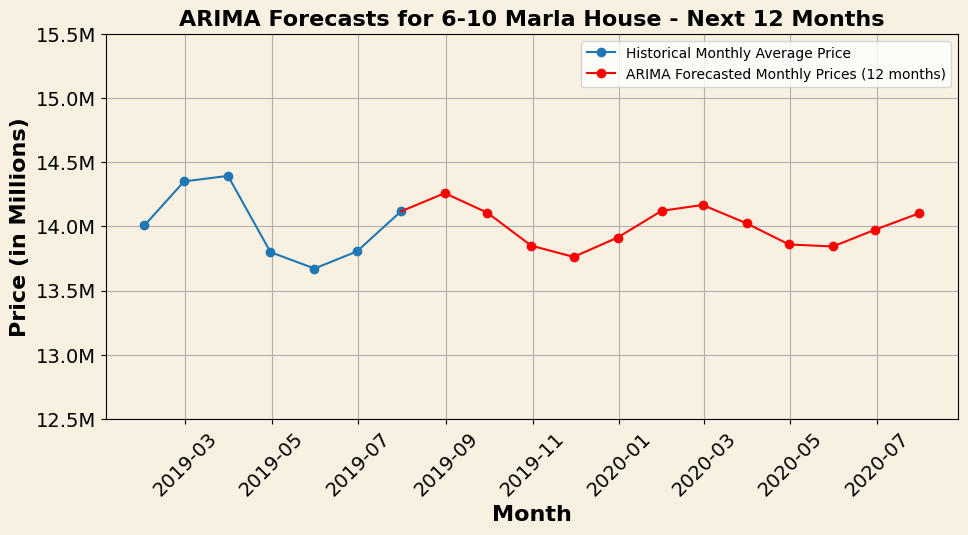

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the data
data_path = '2019.csv'
data = pd.read_csv(data_path)

# Ensure date is in datetime format
data['date_added'] = pd.to_datetime(data['date_added'])

# Filter for plots with specific area sizes
specified_sizes = [6, 6.7, 7, 7.3, 7.5, 8, 8.5, 9, 9.3, 9.5]
data_filtered = data[['date_added', 'Area Size', 'price']]
data_specified = data_filtered[data_filtered['Area Size'].isin(specified_sizes)]

# Resample the data on a monthly basis and calculate the mean
monthly_data_specified = data_specified.set_index('date_added').resample('M').mean().dropna()

# Define ARIMA models to test
arima_orders = [ (2, 1, 1)]
forecast_results = {}
colors = ['red', 'green', 'blue']  # Colors for plotting each model's forecast

# Fit each ARIMA model, forecast the next 12 months, and plot the results
plt.figure(figsize=(11, 5))
plt.plot(
    monthly_data_specified.index,
    monthly_data_specified['price'],
    label='Historical Monthly Average Price',
    marker='o',
    linestyle='-'
)

for i, order in enumerate(arima_orders):
    model = ARIMA(monthly_data_specified['price'], order=order)
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=12)
    forecast_mean = forecast.predicted_mean
    forecast_dates = pd.date_range(start=monthly_data_specified.index[-1], periods=13, freq='M')[1:]
    forecast_results[order] = forecast_mean
    plt.plot(
        forecast_dates,
        forecast_mean,
        color=colors[i],
        marker='o',
        linestyle='-',
        label=f'ARIMA Forecasted Monthly Prices (12 months)'
    )
    
    # Connect the last actual point to the first forecast point
    plt.plot([monthly_data_specified.index[-1], forecast_dates[0]],
             [monthly_data_specified['price'].iloc[-1], forecast_mean.iloc[0]],
             color=colors[i], linestyle='-')

price_min = monthly_data_specified['price'].min()
price_max = monthly_data_specified['price'].max()
plt.ylim([price_min * 0.93, price_max * 1.07])  # Fine-tuned adjustment

plt.title('ARIMA Forecasts for 6-10 Marla House - Next 12 Months', fontsize=16, weight='bold')
plt.xlabel('Month', fontsize=16, weight='bold')
plt.ylabel('Price (in Millions)', fontsize=16, weight='bold')

# Customize the x-axis and y-axis tick labels
plt.xticks(rotation=45, fontsize=14)

# Extract current y-tick positions
yticks = plt.gca().get_yticks()
# Set y-tick positions and labels
plt.yticks(yticks, labels=[f'{label / 1e6:.1f}M' for label in yticks], fontsize=14)

# Set background color to #F8F1E2
plt.gcf().set_facecolor('#F8F1E2')
plt.gca().set_facecolor('#F8F1E2')

plt.legend()
plt.grid(True)
plt.show()



In [3]:
# Check for stationarity using the Augmented Dickey-Fuller test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value {}: {}'.format(key, value))
    return result[1]

# Initial stationarity check
p_value = check_stationarity(data_specified['price'])
d = 0

ADF Statistic: -1.5601162628655945
p-value: 0.5035912019626971
Critical Value 1%: -3.4399324443722814
Critical Value 5%: -2.865768564020576
Critical Value 10%: -2.5690218258831052


ADF Statistic: -1.5601162628655945
p-value: 0.5035912019626971
Critical Value 1%: -3.4399324443722814
Critical Value 5%: -2.865768564020576
Critical Value 10%: -2.5690218258831052
ADF Statistic: -7.800766850220903
p-value: 7.504076416167427e-12
Critical Value 1%: -3.4399324443722814
Critical Value 5%: -2.865768564020576
Critical Value 10%: -2.5690218258831052
The series is stationary with d=1


C:\Users\shaje\AppData\Local\Temp\ipykernel_14360\1576885830.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_specified['price_diff'] = data_specified['price'].diff(d).dropna()


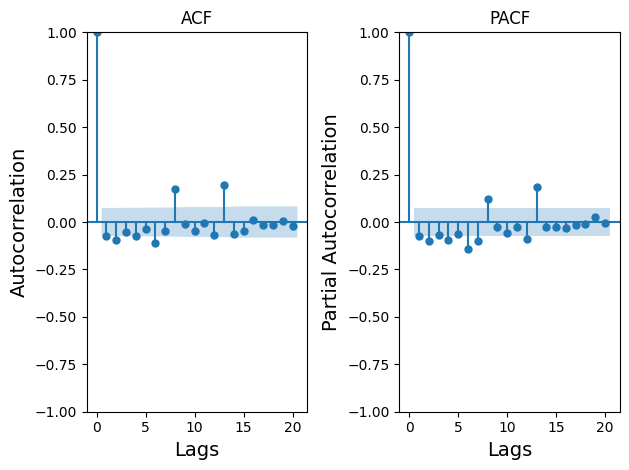

In [4]:
# Check for stationarity using the Augmented Dickey-Fuller test
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value {}: {}'.format(key, value))
    return result[1]

# Initial stationarity check
p_value = check_stationarity(data_specified['price'])
d = 0

# Apply differencing if the series is not stationary
while p_value > 0.05 and d < 2:  # Limit to d < 2 for practical purposes
    d += 1
    data_specified['price_diff'] = data_specified['price'].diff(d).dropna()
    p_value = check_stationarity(data_specified['price_diff'].dropna())

print(f'The series is stationary with d={d}')

# Ensure there are enough data points after differencing
if d > 0:
    diff_data = data_specified['price_diff'].dropna()
else:
    diff_data = data_specified['price']

# Ensure there are enough lags for ACF/PACF plots
max_lags = min(20, len(diff_data) // 2)

# Plot ACF
plt.subplot(121)
plot_acf(diff_data, lags=max_lags, ax=plt.gca())
plt.title('ACF')
plt.xlabel('Lags', fontsize=14)  # Adjust fontsize as needed
plt.ylabel('Autocorrelation', fontsize=14)  # Adjust fontsize as needed

# Plot PACF
plt.subplot(122)
plot_pacf(diff_data, lags=max_lags, ax=plt.gca())
plt.title('PACF')
plt.xlabel('Lags', fontsize=14)  # Adjust fontsize as needed
plt.ylabel('Partial Autocorrelation', fontsize=14)  # Adjust fontsize as needed

plt.tight_layout()  # Ensures plots are properly spaced
plt.show()
# Based on ACF and PACF plots, we can suggest p and q values
# For demonstration purposes, we will use (p=1, d=d, q=1)
p = 1
q = 1